<a href="https://colab.research.google.com/github/ras1364/DetectFakeReviewsUsing-Sentence_BERT/blob/main/FakeReviewDetectionUsingSentenceBertVer3_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
import itertools, nltk, snowballstemmer, re

!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X_test = pd.read_csv("/content/sample_data/X_test.csv")
X_train = pd.read_csv("/content/sample_data/X_train.csv")
y_test = pd.read_csv("/content/sample_data/y_test.csv")
y_train = pd.read_csv("/content/sample_data/y_train.csv")

In [ ]:
max_length = 384
# for x in range(0,len(X_train)):
#   line = X_train.loc[x].at["stemmed_text_data"]
#   if max_length < len(line.split()) :
#     max_length = len(line.split())

print(max_length)


384


In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/sentence-t5-base')

text = ['This is a sentence to get vector', 'This one too']
inputs = tokenizer(text, return_tensors='tf', padding=True)
inputs

{'input_ids': <tf.Tensor: shape=(2, 9), dtype=int32, numpy=
array([[  100,    19,     3,     9,  7142,    12,   129, 12938,     1],
       [  100,    80,   396,     1,     0,     0,     0,     0,     0]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 9), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int32)>}

In [ ]:
X_train_encoded = sbert_model.encode(X_train["stemmed_text_data"] ,  show_progress_bar=True)
X_test_encoded = sbert_model.encode(X_test["stemmed_text_data"], show_progress_bar=True)

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
X_train_encoded.shape

(1120, 384)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
# define and fit the final model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
   ] 
model = Sequential()
model.add(Dense(64, input_shape=(384,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                24640     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 26,753
Trainable params: 26,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train_encoded,y_train, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
18/18 [==============================] - 2s 8ms/step - loss: 0.6871 - accuracy: 0.6196 - precision: 0.6102 - recall: 0.6625
Epoch 2/50
18/18 [==============================] - 0s 5ms/step - loss: 0.6566 - accuracy: 0.7098 - precision: 0.7327 - recall: 0.6607
Epoch 3/50
18/18 [==============================] - 0s 4ms/step - loss: 0.6042 - accuracy: 0.7357 - precision: 0.7444 - recall: 0.7179
Epoch 4/50
18/18 [==============================] - 0s 5ms/step - loss: 0.5470 - accuracy: 0.7598 - precision: 0.7650 - recall: 0.7500
Epoch 5/50
18/18 [==============================] - 0s 5ms/step - loss: 0.4962 - accuracy: 0.7768 - precision: 0.7739 - recall: 0.7821
Epoch 6/50
18/18 [==============================] - 0s 4ms/step - loss: 0.4637 - accuracy: 0.7982 - precision: 0.8175 - recall: 0.7679
Epoch 7/50
18/18 [==============================] - 0s 5ms/step - loss: 0.4349 - accuracy: 0.8098 - precision: 0.8104 - recall: 0.8089
Epoch 8/50
18/18 [==============================] - 0s 

In [ ]:
model.evaluate(X_test_encoded, y_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.7958 - precision: 0.8114 - recall: 0.7708


[0.6980961561203003,
 0.7958333492279053,
 0.8114035129547119,
 0.7708333134651184]

In [ ]:
y_predicted = model.predict(X_test_encoded)
y_predicted = y_predicted.flatten()

15/15 [==============================] - 0s 2ms/step


In [ ]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[197,  43],
       [ 55, 185]])

Text(33.0, 0.5, 'Truth')

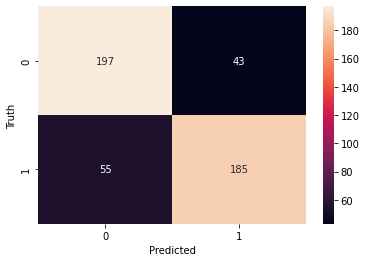

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       240
           1       0.81      0.77      0.79       240

    accuracy                           0.80       480
   macro avg       0.80      0.80      0.80       480
weighted avg       0.80      0.80      0.80       480

